In [ ]:
import os, warnings, re
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Optional, Tuple
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pmdarima as pm

from models import LSTMForecaster, CNNLSTMForecaster, TrainConfig, run_ensemble, save_ckp, load_ckp
from backups.trainer import train_cnnlstm, train_lstm 
from utils import evaluate_mse_over_test, impute_features_with_staleness, build_all_targets, GeneralPredictor, InferenceConfig, EnsembleWeights, plot_true_vs_pred, plot_true_vs_pred_by_lag_arrays
from adapters import LSTMAdapter, CNNLSTMAdapter
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())


torch: 2.6.0+cu124 | cuda: True


----------

In [ ]:
from dataprep import dataprep 
# ---- Paths (adjust if needed)
PRICES_PATH = "../data/train.csv"            # must include 'date_id' + asset columns
TP_PATH     = "../data/target_pairs.csv"     # columns: target, lag, pair
LABELS_PATH = "../data/train_labels.csv"     # optional sanity check

# ---- Load & sort
def drop_last_n_rows(df:pd.DataFrame, n):
    rows = len(df) - n 
    return df.iloc[:rows, :]
## Note: To avoid overfitting by target leakage, skipfooter=90 was used to skip the 90 bottom rows.  
prices_df = pd.read_csv(PRICES_PATH, skipfooter=0, engine='python').sort_values("date_id").reset_index(drop=True)
target_pairs_df = pd.read_csv(TP_PATH)

# ---- Build targets from prices
targets_df = build_all_targets(prices_df, target_pairs_df, date_col="date_id", id_col="target")
print("targets_df shape:", targets_df.shape)
targets_df.head()
target_cols = targets_df.columns 

# ---- Missing value handling
feature_cols = [c for c in prices_df.columns if c!='date_id'] 
X_imp, X_stale, X_miss = impute_features_with_staleness(
    prices_df[['date_id']+feature_cols], 
    date_col='date_id', 
    cap_days=None
    )

Xi = X_imp.set_index("date_id")[feature_cols] 
Xs = X_stale.set_index("date_id")[feature_cols].add_suffix("_stale")
Xm = X_miss.set_index("date_id")[feature_cols].add_suffix("_miss") 
X_full = pd.concat([Xi, Xs, Xm], axis=1).astype(float)
X_full = (X_full.reset_index() # index -> column 
                .rename(columns={'index':'date_id'}) 
        )

Y_full = targets_df.to_numpy(float) 
X_full_np = X_full.loc[targets_df.index].to_numpy(float) 

# ---- Configs
cfg = TrainConfig(
    input_len=64, 
    output_len=1, 
    epochs=25, 
    hidden_size=256, 
    dropout=0.3)

targets_df shape: (1917, 424)


In [3]:
# Train your model
lstm_model, x_scaler,_ , _ = train_lstm(Y_full, cfg, X=X_full_np) 
save_ckp('checkpoints',lstm_model,x_scaler, X_cols=X_full.columns, Y_cols=targets_df.columns)

Your device: cuda
 >> val_loss(best): 0.0014638622524216771


In [4]:
import json 
ckp_dir = "checkpoints"

# Load the exact training schemas
train_feature_cols = json.load(open(os.path.join(ckp_dir, "feature_cols.json")))
train_target_cols  = json.load(open(os.path.join(ckp_dir, "target_cols.json")))

# Rebuild with the SAME hyperparams used in training
model_kwargs = dict(
    input_size=len(train_feature_cols),       # <- MUST be 1672 to match your checkpoint
    hidden_size=cfg.hidden_size,
    num_layers=getattr(cfg, "num_layers", 1),
    dropout=cfg.dropout,
    output_len=cfg.output_len,               # 1
    num_targets=len(train_target_cols)       # 424
)

lstm_model, x_scaler, feature_cols, target_cols = load_ckp(
    dir="checkpoints",
    model_class=LSTMForecaster,        # your nn.Module class
    model_kwargs=model_kwargs,
    device="cpu",
)


# X_full_df: your dense, imputed feature history (DataFrame indexed by date_id)
# Align columns to the training schema; create any missing cols if needed
missing = [c for c in train_feature_cols if c not in X_full.columns]
if missing:
    # sensible defaults for engineered cols:
    add = pd.DataFrame(index=X_full.index, columns=missing)
    for c in missing:
        if c.endswith("_miss"):
            add[c] = 0.0
        elif c.endswith("_stale"):
            add[c] = 0.0
        else:
            add[c] = np.nan  # base feature missing -> fill with last obs later if needed
    X_full_df = pd.concat([X_full, add], axis=1)

# Reorder to training order
X_warm = X_full[train_feature_cols].copy()   # <- indexed by date_id, dense
Y_warm = targets_df                                     # optional; not needed by LSTM adapter

# Lag panel column orders from headers (once)
def read_lag_cols(path):
    df = pd.read_csv(path, nrows=1)
    return [c for c in df.columns if c not in ("date_id","label_date_id")]

cols_by_lag = {
    1: read_lag_cols("../data/lagged_test_labels/test_labels_lag_1.csv"),
    2: read_lag_cols("../data/lagged_test_labels/test_labels_lag_2.csv"),
    3: read_lag_cols("../data/lagged_test_labels/test_labels_lag_3.csv"),
    4: read_lag_cols("../data/lagged_test_labels/test_labels_lag_4.csv"),
}

# Register models (start with your LSTM; you can add more later)
adapters = {
    "lstm": LSTMAdapter(lstm_model, x_scaler, target_cols),
    # "cnn_lstm": CNNLSTMAdapter(...),
    # "fedformer": FEDFormerAdapter(...),
    # "prophet": ProphetAdapter(target_cols),
}

# Ensemble weights (pure LSTM for now)
weights = EnsembleWeights(global_w={"lstm": 1.0})

# Build predictor
inf_cfg = InferenceConfig(input_len=cfg.input_len, max_lag=4, feature_cols=feature_cols, target_cols=target_cols)
gp = GeneralPredictor(cfg=inf_cfg, adapters=adapters, cols_by_lag=cols_by_lag, X_warm=X_warm, Y_warm=None, weights=weights)


In [5]:
# Run it with your predictor:
result = evaluate_mse_over_test(
    test_csv_path="../data/test.csv",
    lag_dir="../data/lagged_test_labels",
    predict_row_fn=lambda tb,b1,b2,b3,b4,d: gp.predict_one(tb,b1,b2,b3,b4,d)
)
# Plot the prediction values and true values 

 --- Model: LSTM
Prediction --- done!  |  Duration: 0.00725245475769043
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.00606989860534668
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005148649215698242
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005283355712890625
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005476951599121094
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006359577178955078
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0053217411041259766
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005475521087646484
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005614042282104492
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005820274353027344
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006121397018432617
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005196809768676758
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006002902984619141
 --- Model: LSTM
Prediction --- done!  |  Duration: 

In [6]:
print("MSE overall:", result['overall']) 
print("MSE per lag:", result["per_lag"]) 

MSE overall: 0.0014713259005505286
MSE per lag: {1: 0.0010605111796182748, 2: 0.0012785388852650092, 3: 0.0017061145631760033, 4: 0.0018578662727924684}


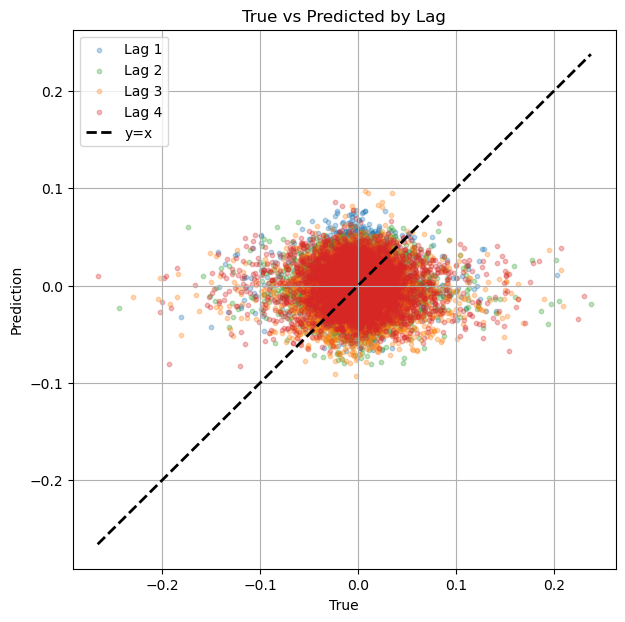

In [ ]:
# Scatter plot 
plot_true_vs_pred_by_lag_arrays(result["by_lag_arrays"], sample_size=5000)

-----
CNN + LSTM


In [16]:
# ---- Paths (adjust if needed)
PRICES_PATH = "../data/train.csv"            # must include 'date_id' + asset columns
TP_PATH     = "../data/target_pairs.csv"     # columns: target, lag, pair
LABELS_PATH = "../data/train_labels.csv"     # optional sanity check

# ---- Load & sort
def drop_last_n_rows(df:pd.DataFrame, n):
    rows = len(df) - n 
    return df.iloc[:rows, :]
## Note: To avoid overfitting by target leakage, skipfooter=90 was used to skip the 90 bottom rows.  
prices_df = pd.read_csv(PRICES_PATH, skipfooter=0, engine='python').sort_values("date_id").reset_index(drop=True)
target_pairs_df = pd.read_csv(TP_PATH)

# ---- Build targets from prices
targets_df = build_all_targets(prices_df, target_pairs_df, date_col="date_id", id_col="target")
print("targets_df shape:", targets_df.shape)
targets_df.head()
target_cols = targets_df.columns 

# ---- Missing value handling
feature_cols = [c for c in prices_df.columns if c!='date_id'] 
X_imp, X_stale, X_miss = impute_features_with_staleness(
    prices_df[['date_id']+feature_cols], 
    date_col='date_id', 
    cap_days=None
    )

Xi = X_imp.set_index("date_id")[feature_cols] 
Xs = X_stale.set_index("date_id")[feature_cols].add_suffix("_stale")
Xm = X_miss.set_index("date_id")[feature_cols].add_suffix("_miss") 
X_full = pd.concat([Xi, Xs, Xm], axis=1).astype(float)
X_full = (X_full.reset_index() # index -> column 
                .rename(columns={'index':'date_id'}) 
        )

Y_full = targets_df.to_numpy(float) 
X_full_np = X_full.loc[targets_df.index].to_numpy(float) 

# ---- Configs
cfg = TrainConfig(
    input_len=64, 
    output_len=1, 
    epochs=25, 
    hidden_size=256, 
    dropout=0.3,
)

targets_df shape: (1917, 424)


In [17]:
# Build training arrays (multivariate)
Y_full = targets_df.to_numpy(float)                                  # (T, 424)
X_full_np = X_full.loc[targets_df.index].to_numpy(float)          # (T, F_train)

# Train
cnn_kwargs = dict(conv_channels=128, kernel_size=5, num_conv_layers=2,
                  lstm_hidden=cfg.hidden_size, lstm_layers=getattr(cfg, "num_layers", 1),
                  dropout=cfg.dropout, output_len=cfg.output_len)
cnn_model, x_scaler, meta = train_cnnlstm(Y_full, cfg, X=X_full_np, model_kwargs=cnn_kwargs)

Your device: cuda


/root/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training CNN+LSTM:   0%|          | 0/25 [00:00<?, ?epoch/s]

Early stopping: 10 bad epochs
Best val_loss in training: 0.0009057536954060197


In [18]:
# Save (reuse your save_ckp)
save_ckp("checkpoints_cnnlstm", cnn_model, x_scaler, X_full.columns, targets_df.columns)


In [19]:
# Load schemas to rebuild the exact shape
import json 
train_feature_cols = json.load(open("checkpoints_cnnlstm/feature_cols.json"))
train_target_cols  = json.load(open("checkpoints_cnnlstm/target_cols.json"))

# Rebuild model skeleton and load state_dict
model_kwargs = dict(
    input_size=len(train_feature_cols),
    num_targets=len(train_target_cols),
    conv_channels=128, 
    kernel_size=5, 
    num_conv_layers=2,
    lstm_hidden=cfg.hidden_size, 
    lstm_layers=getattr(cfg, "num_layers", 1),
    dropout=cfg.dropout, 
    output_len=cfg.output_len
)
cnn_model = CNNLSTMForecaster(**model_kwargs)
state = torch.load("checkpoints_cnnlstm/lstm.pt", map_location="cpu")   # same filename if you reused save_ckp
cnn_model.load_state_dict(state)
cnn_model.eval()

# Load scaler
import joblib
x_scaler = joblib.load("checkpoints_cnnlstm/scaler.pkl")

# Warm history in exact training order
X_warm = X_full[train_feature_cols].loc[targets_df.index].copy()

# Build adapter set (you can ensemble with LSTM/ARIMA later)
adapters = {
    "cnn_lstm": CNNLSTMAdapter(cnn_model, x_scaler, train_target_cols),
    # "lstm": LSTMAdapter(lstm_model, lstm_scaler, train_target_cols),
    # "arima": ARIMAAdapter(...),
}
weights = EnsembleWeights(global_w={"cnn_lstm": 1.0})

inf_cfg = InferenceConfig(
    input_len=cfg.input_len,
    max_lag=4,
    feature_cols=train_feature_cols,
    target_cols=train_target_cols,
    model_order=list(adapters.keys())
)
# Lag panel column orders from headers (once)
def read_lag_cols(path):
    df = pd.read_csv(path, nrows=1)
    return [c for c in df.columns if c not in ("date_id","label_date_id")]

cols_by_lag = {
    1: read_lag_cols("../data/lagged_test_labels/test_labels_lag_1.csv"),
    2: read_lag_cols("../data/lagged_test_labels/test_labels_lag_2.csv"),
    3: read_lag_cols("../data/lagged_test_labels/test_labels_lag_3.csv"),
    4: read_lag_cols("../data/lagged_test_labels/test_labels_lag_4.csv"),
}
gp = GeneralPredictor(cfg=inf_cfg, 
                      adapters=adapters,
                      cols_by_lag=cols_by_lag, 
                      X_warm=X_warm, 
                      Y_warm=None, 
                      weights=weights)


In [20]:
from utils import evaluate_mse_over_test2
scores = evaluate_mse_over_test2(
    test_csv_path='../data/test.csv', 
    lag_dir='../data/lagged_test_labels', 
    predict_row_fn=lambda tb,b1,b2,b3, b4,d: gp.predict_one(tb,b1,b2,b3,b4,d)
)
print(scores) 


 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0060117244720458984
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006128549575805664
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0055310726165771484
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005690336227416992
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.00559687614440918
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0066776275634765625
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0060842037200927734
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006696939468383789
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005197286605834961
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006068229675292969
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005530118942260742
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.008277177810668945
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.007254838943481445
 --- Model: LSTM
Prediction --- done!  |  Durati

 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005918025970458984
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006262540817260742
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.007838249206542969
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0052263736724853516
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.00521087646484375
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005287647247314453
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006105899810791016
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006009578704833984
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.005301713943481445
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.008555173873901367
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.007371664047241211
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.008234739303588867
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.0063931941986083984
 --- Model: LSTM
Prediction --- done!  |  Duration

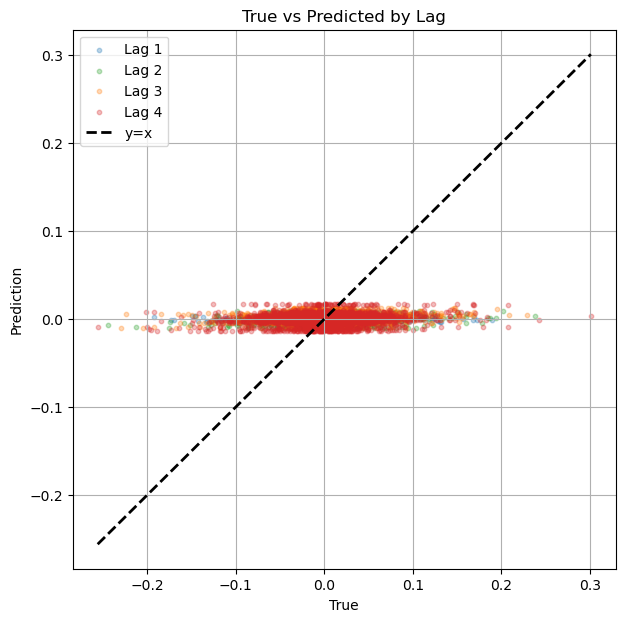

In [21]:
from utils import evaluate_preds_by_lag
by_lag = evaluate_preds_by_lag(
    test_csv_path='../data/test.csv',
    lag_dir='../data/lagged_test_labels',
    predict_row_fn=lambda tb,b1,b2,b3,b4,d: gp.predict_one(tb,b1,b2,b3,b4,d)
)
plot_true_vs_pred_by_lag_arrays(by_lag, sample_size=5000)

In [14]:
import polars as pl
import numpy as np
import pandas as pd
from utils import concat_lag_labels_rowwise_safe
d = 1827
test = pl.read_csv("../data/test.csv")
l1 = pl.read_csv("../data/lagged_test_labels/test_labels_lag_1.csv")
l2 = pl.read_csv("../data/lagged_test_labels/test_labels_lag_2.csv")
l3 = pl.read_csv("../data/lagged_test_labels/test_labels_lag_3.csv")
l4 = pl.read_csv("../data/lagged_test_labels/test_labels_lag_4.csv")

tb = test.filter(pl.col("date_id")==d)
b = {1:l1.filter(pl.col("date_id")==d),
     2:l2.filter(pl.col("date_id")==d),
     3:l3.filter(pl.col("date_id")==d),
     4:l4.filter(pl.col("date_id")==d)}

# 1) Ground-truth
y_true, cols_true = concat_lag_labels_rowwise_safe((b[1],b[2],b[3],b[4]))
print("y_true len:", len(y_true), " first targets:", cols_true[:5])

# 2) Prediction row
pred_row = gp.predict_one(tb, b[1], b[2], b[3], b[4], d)
print("pred_row shape:", pred_row.shape)
print("pred_row first 5 cols:", list(pred_row.columns)[:5])

# 3) Length + finites
y_pred = pred_row.to_numpy().reshape(-1)
print("lens:", len(y_true), len(y_pred))
print("finite counts -> true:", np.isfinite(y_true).sum(), " pred:", np.isfinite(y_pred).sum())


y_true len: 0  first targets: ['target_0', 'target_1', 'target_2', 'target_3', 'target_4']
 --- Model: LSTM
Prediction --- done!  |  Duration: 0.006306886672973633
pred_row shape: (1, 424)
pred_row first 5 cols: ['target_0', 'target_1', 'target_2', 'target_3', 'target_4']
lens: 0 424
finite counts -> true: 0  pred: 424


In [15]:
y_pred

array([ 6.89430162e-04,  4.76330519e-04,  5.79947606e-04,  9.81371850e-05,
       -1.59978867e-04, -1.39199197e-04, -9.98020172e-04, -8.69683921e-04,
       -1.35827623e-03,  2.04006210e-04, -8.38710926e-04,  2.62942165e-04,
       -1.94778666e-03, -1.89519487e-04,  2.81704590e-04,  8.33403319e-05,
        1.41655467e-03, -2.41554528e-03,  5.71187120e-04,  7.05849379e-06,
        5.88059425e-04, -1.94182619e-04, -3.21630388e-04,  9.73925926e-05,
        4.74475324e-04, -1.44188467e-04,  2.32281163e-04, -1.58008188e-03,
       -1.03024673e-03, -6.27008267e-04, -3.18400562e-05, -8.76077916e-04,
        2.26038508e-04,  1.27734616e-04,  3.83425504e-05, -2.66020186e-04,
       -5.84676862e-04, -1.09792314e-03, -2.66439980e-04,  3.84807587e-04,
        4.08194959e-04,  1.13790855e-03, -1.12129934e-03, -1.22357160e-04,
        9.96073708e-04,  3.23038548e-04, -6.11290336e-04,  3.05327121e-04,
        2.08805315e-03, -1.81407854e-03, -1.09909161e-03,  8.94002616e-04,
       -3.54563817e-04, -

---
TCN (Temporal Convolutional Network + residual blocks)

In [1]:
from dataprep import dataprep 

dataprep_tcn = dataprep()
dataprep_tcn.one_shot_prep() 

targets_df shape: (1827, 424)
Final shapes report:
 >> features: (1827, 1672)
 >> targets: (1827, 424)


In [2]:
dataprep_tcn.targets_df

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
date_id,,,,,,,,,,,,,,,,,,,,,
0,0.005948,-0.002851,-0.004675,-0.000639,NaN,NaN,-0.006729,0.006066,NaN,0.003446,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,0.021284,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,0.001048,0.023836,-0.008934,-0.022060,NaN,NaN,0.037449,0.007658,NaN,-0.026844,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,0.001700,-0.024618,0.011943,0.004778,NaN,NaN,-0.012519,-0.016896,NaN,0.014843,...,NaN,0.036880,-0.015189,NaN,0.008118,0.001079,NaN,-0.015102,NaN,-0.033010
4,-0.003272,0.005234,0.006856,0.013312,0.023953,0.010681,-0.011649,0.002019,0.003897,-0.008985,...,NaN,0.004937,NaN,-0.006673,-0.016105,-0.004885,NaN,NaN,0.009514,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,0.003436,0.000386,0.007569,-0.006153,NaN,NaN,0.011023,-0.009502,NaN,0.000473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1823,0.015150,-0.031044,0.001299,0.015906,0.012631,0.010133,-0.031975,-0.012297,0.008737,0.011488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1824,0.000928,0.017252,0.002840,0.009355,0.016741,0.009989,0.004816,-0.002361,0.002800,-0.027678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
from models import build_tcn, TrainConfig
from optimization import run_optuna, HPOConfig
from trainer import train_eval_fn

study = run_optuna(
    build_model_fn = build_tcn,
    train_eval_fn= train_eval_fn,
    base_cfg = TrainConfig(epochs=30, lr=1e-3, batch_size=64, dropout=0.1),
    X_hist = dataprep_tcn.X_full_np,
    Y_hist = dataprep_tcn.Y_full_np, 
    hpo_cfg = HPOConfig(max_trials=40, pruner='median')
)

print("Best value:", study.best_value)
print("Best params", study.best_params)

[I 2025-09-17 17:52:43,873] A new study created in memory with name: no-name-4bb45a37-fd20-4639-ac23-310c8c915aa9
/root/anaconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
[W 2025-09-17 17:53:03,176] Trial 0 failed with parameters: {'input_len': 96, 'dropout': 0.4753571532049581, 'lr': 0.0006504856968981271, 'weight_decay': 9.846738873614555e-06, 'batch_size': 32, 'hidden_size': 128, 'cnn_kernel': 3, 'cnn_dilation': 8, 'tcn_blocks': 4, 'tcn_channels': 256, 'tcn_kernel': 5, 'lr_policy': 'constant'} because of the following error: The value None could not be cast to float..
[W 2025-09-17 17:53:03,177] Trial 0 failed with value None.
/root/anaconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.w

ValueError: No trials are completed yet.

---
Download pretrained model from HuggingFace and Do Finetuining

In [1]:
from huggingface_hub import notebook_login
notebook_login() 